In [466]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc


In [467]:
# Load dataset
df = pd.read_csv('../Assets/Data/Lung Cancer Dataset.csv')



In [468]:


# Remove rows with missing values
df = df.dropna()

# Convert 'PULMONARY_DISEASE' column to integer (No → 0, Yes → 1)
if 'PULMONARY_DISEASE' in df.columns:
    df['PULMONARY_DISEASE'] = df['PULMONARY_DISEASE'].map({'No': 0, 'Yes': 1, 'YES': 1, 'NO': 0}).fillna(0).astype(int)

# ✅ Check if encoding is needed
categorical_cols = ['GENDER', 'SMOKING', 'EXPOSURE_TO_POLLUTION', 'LONG_TERM_ILLNESS', 
                    'FAMILY_HISTORY', 'SMOKING_FAMILY_HISTORY', 'ALCOHOL_CONSUMPTION']

for col in categorical_cols:
    print(f"🔹 {col} Unique Values: {df[col].unique()}")  # Check if encoding is necessary

# 🚀 No encoding needed if all values are already numeric!


🔹 GENDER Unique Values: [1 0]
🔹 SMOKING Unique Values: [1 0]
🔹 EXPOSURE_TO_POLLUTION Unique Values: [1 0]
🔹 LONG_TERM_ILLNESS Unique Values: [0 1]
🔹 FAMILY_HISTORY Unique Values: [0 1]
🔹 SMOKING_FAMILY_HISTORY Unique Values: [0 1]
🔹 ALCOHOL_CONSUMPTION Unique Values: [1 0]


In [469]:
# ✅ Select features (excluding 'PULMONARY_DISEASE' as target and 'GENDER' to remove bias)
X = df.drop(columns=['PULMONARY_DISEASE', 'GENDER'])
y = df['PULMONARY_DISEASE']

# ✅ Split dataset into training and testing sets (80%-20%) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Define numerical columns to scale
numerical_cols = ['AGE', 'OXYGEN_SATURATION', 'ENERGY_LEVEL', 'STRESS_IMMUNE']

# ✅ Apply StandardScaler only to numerical features
scaler = StandardScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# ✅ Save the scaler for future use in predictions
joblib.dump(scaler, '../Assets/Models/scaler.pkl')

# ✅ Display summary to verify changes
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")
print(f"Scaled Features Sample:\n{X_train[numerical_cols].head()}")


Training set size: (4000, 16), Testing set size: (1000, 16)
Scaled Features Sample:
           AGE  OXYGEN_SATURATION  ENERGY_LEVEL  STRESS_IMMUNE
1646  0.426826          -0.144945     -0.602346       1.926506
2041 -1.355726          -0.133908     -0.010986       1.926506
2842 -1.737701          -1.697252     -2.245686       1.926506
2198 -1.674039           0.988952     -1.804056       1.926506
644  -0.273462          -0.397527      0.561760      -0.519074


In [470]:
# ✅ Define models with optimized hyperparameters
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='linear', probability=True),
    "XGBoost": XGBClassifier(eval_metric='logloss', verbosity=1)
}

# ✅ Train models
trained_models = {}
for name, model in models.items():
    print(f"🔹 Training {name}...")
    model.fit(X_train, y_train)  # Using improved variable names
    trained_models[name] = model

# ✅ Save all trained models
model_paths = {
    "Logistic Regression": "../Assets/Models/logistic_regression.pkl",
    "Random Forest": "../Assets/Models/random_forest.pkl",
    "SVM": "../Assets/Models/svm_model.pkl",
    "XGBoost": "../Assets/Models/xgboost_model.pkl"
}

for name, path in model_paths.items():
    joblib.dump(trained_models[name], path)
    print(f"✅ {name} model saved at: {path}")

# ✅ Confirmation message
print("\n🚀 All models trained and saved successfully!")

🔹 Training Logistic Regression...
🔹 Training Random Forest...
🔹 Training SVM...
🔹 Training XGBoost...
✅ Logistic Regression model saved at: ../Assets/Models/logistic_regression.pkl
✅ Random Forest model saved at: ../Assets/Models/random_forest.pkl
✅ SVM model saved at: ../Assets/Models/svm_model.pkl
✅ XGBoost model saved at: ../Assets/Models/xgboost_model.pkl

🚀 All models trained and saved successfully!



📌 Model Performance Evaluation:

🔹 Logistic Regression Performance:
✅ Accuracy: 0.8880
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       593
           1       0.85      0.88      0.86       407

    accuracy                           0.89      1000
   macro avg       0.88      0.89      0.88      1000
weighted avg       0.89      0.89      0.89      1000

📊 AUC Score: 0.9261

🔹 Random Forest Performance:
✅ Accuracy: 0.9060
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       593
           1       0.89      0.88      0.88       407

    accuracy                           0.91      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.91      0.91      0.91      1000

📊 AUC Score: 0.9174

🔹 SVM Performance:
✅ Accuracy: 0.8780
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       593
           1       0.

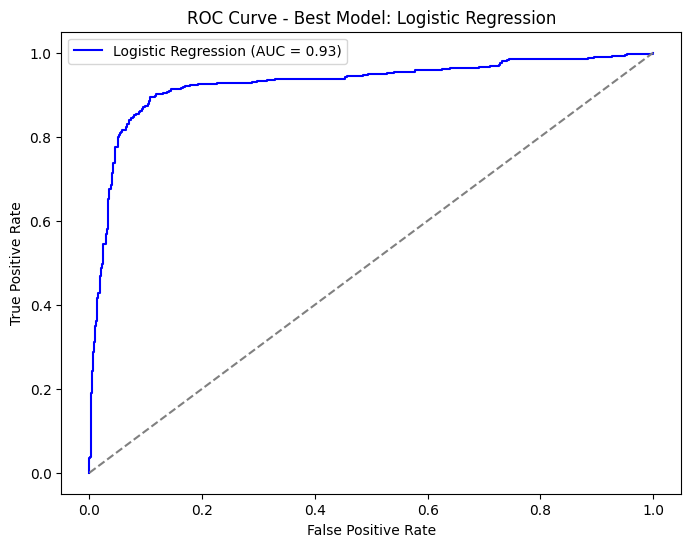

🏆 Best Model: Logistic Regression with AUC = 0.9261



In [471]:
# ✅ Define models dictionary
models = {
    "Logistic Regression": log_model,
    "Random Forest": rf_model,
    "SVM": svm_model,
    "XGBoost": xgb_model
}

# ✅ Evaluate all models
best_model = None
best_auc = 0

print("\n📌 Model Performance Evaluation:\n")
for name, model in models.items():
    # Make predictions
    y_pred = model.predict(test_features)

    # Print evaluation metrics
    print(f"🔹 {name} Performance:")
    print(f"✅ Accuracy: {accuracy_score(test_target, y_pred):.4f}")
    print(classification_report(test_target, y_pred))

    # Calculate AUC (if model supports probability prediction)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(test_features)[:, 1]
        fpr, tpr, _ = roc_curve(test_target, y_prob)
        roc_auc = auc(fpr, tpr)

        print(f"📊 AUC Score: {roc_auc:.4f}\n")

        # Track the best model based on AUC
        if roc_auc > best_auc:
            best_auc = roc_auc
            best_model = (name, model, fpr, tpr, roc_auc)

# ✅ ROC Curve for the Best Model
if best_model:
    name, model, fpr_best, tpr_best, best_auc = best_model

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_best, tpr_best, label=f'{name} (AUC = {best_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Best Model: {name}')
    plt.legend()
    plt.show()

    print(f"🏆 Best Model: {name} with AUC = {best_auc:.4f}\n")